In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from environment import Environment, DirectedTree, DEFAULT, CONSTITUENT
from prouter import Router
from matplotlib.patches import Rectangle, Circle
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import PatchCollection
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pathlib import Path

## Set plot-style to seaborn paper

In [2]:
#plt.style.use("ggplot")
plt.style.use("seaborn")
plt.style.use("seaborn-paper")

In [3]:
def preparation_env():
    env = Environment()
    #env.read_swmmoutfile(r"C:\Users\albert/Documents/SWMMpulse/HS_calib_120_simp.out")
    env.read_swmmoutfile(r"demo_swmm_out.out")
    #graph = DirectedTree.from_swmm(r"C:\Users\albert/Documents/SWMMpulse/HS_calib_120_simp.inp")
    graph = DirectedTree.from_swmm(r"demo_swmm-inp.inp")
    #node_data = pd.read_csv(r"C:\Users\albert/Documents/SWMMpulse/HS_calib_120_simp/pop_node_data.csv")
    node_data = pd.read_csv(r"pop_node_data.csv")
    node_data = node_data.set_index("NAME").to_dict(orient="index")
    graph.add_nodevalues(node_data)
    env.add_graph(graph)
    return env

def set_infectivity(r_inf, env):
    env.information["groups"][0]["weight"] = 1 - r_inf
    env.information["groups"][1]["weight"] = r_inf
    return env

## Bristol defecation distribution

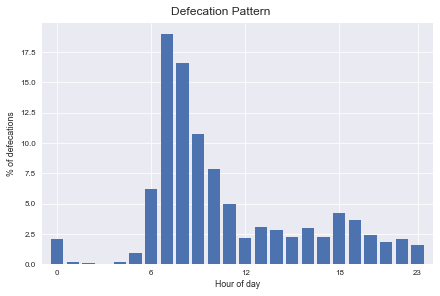

In [25]:
fig, ax = plt.subplots(figsize=[6,4], constrained_layout=True)
fig.suptitle("Defecation Pattern")


ax.set(xlabel="Hour of day", ylabel="% of defecations",
       xlim=[-1,24], xticks=[0, 6, 12, 18, 23])
ax.bar(x=np.arange(0,24), height=DEFAULT.PATTERN_BRISTOL)

plt.savefig(r"C:\Users\albert\Nextcloud\Documents\Doktorat\swmmPulse\paper\grafics\def_pat.svg")
plt.savefig(r"C:\Users\albert\Nextcloud\Documents\Doktorat\swmmPulse\paper\grafics\def_pat.png")

## Traveltime Distribution

In [3]:
fdir = Path(r"C:\Users\albert\Documents\SWMMpulse")

In [11]:
def read_packetfiles(n=10):
    packet_dir = fdir/"00_packets"/"00_run2"
    for f in list(packet_dir.iterdir())[:1]:
        df = pd.read_json(f)
    return df

In [24]:
def read_routetablefiles(n=10):
    routetable_dir = fdir/"01_routetables"/"00_run2"
    for f in list(routetable_dir.iterdir())[:1]:
        s = pd.read_json(f, typ="series")
    return s.rename("ta")

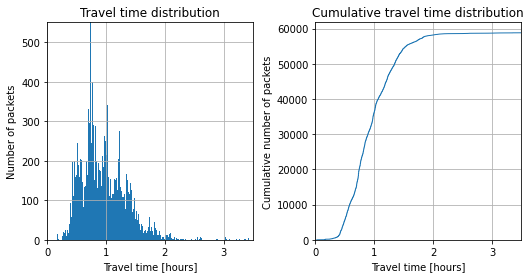

In [63]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[8.5,4])

df_packets = read_packetfiles()
s_ta = read_routetablefiles()
df_packets = df_packets.set_index("pid").join(s_ta)
df_packets["tt"] = (df_packets["ta"] - df_packets["t0"]) * 10 / (60 * 60)
df_packets.loc[df_packets["tt"] < 6, ["tt"]].hist(bins=1000, ax=axs[0])
df_packets.loc[df_packets["tt"] < 6, ["tt"]].hist(bins=1000, ax=axs[1], cumulative=True, histtype="step")
df_packets.to_parquet(fdir/"plots"/"grfk_travel_time"/"travel_time.parquet")

axs[0].set(xlabel="Travel time [hours]",
       ylabel="Number of packets",
       ylim=[0,550],
       xlim=[0,3.5],
       title="Travel time distribution")
axs[1].set(xlabel="Travel time [hours]",
       ylabel="Cumulative number of packets",
       xlim=[0,3.5],
       title="Cumulative travel time distribution")

plt.savefig(fdir/"plots"/"grfk_travel_time"/"travel_time.png", dpi=700)
plt.savefig(fdir/"plots"/"grfk_travel_time"/"travel_time.svg")

In [53]:
print(f"Mean traveltime: {df_packets['tt'].mean():.2f} hours")
print(f"Median traveltime: {df_packets['tt'].median():.2f} hours")

Mean traveltime: 1.00 hours
Median traveltime: 0.89 hours


## Comparision dispersion fick / simplified

In [7]:
path = r"C:\Users\albert\Documents\SWMMpulse"
router = Router()
env = preparation_env()
groot = env.graph.root

cov = env.information["constituents"]["Cov-RNA"]
cov["fractions"] = [1]
cov["skewedness"] = [[1,1]]
env.information["constituents"]["Cov-RNA"] = cov

router.add_environment(env)

#generate packets
packets = router.environment.get_packets()

#generate routetable
routetable = router.route(packets=packets)

#calculate timeseries data at network root
processed = router.postprocess(routetable, packets, router.environment.information["constituents"].get(CONSTITUENT.COV))

#create dataframe
timeseries = pd.DataFrame(processed, index=pd.date_range("2000-01-01", freq="10S", periods=8640))
#calculate timeseries for entire catchment

In [8]:
try:
    packets.set_index("pid", inplace=True)
except:
    pass
packets["tm"] = pd.Series(routetable[groot])
packets["dt"] = packets["tm"] - packets["t0"]
packets["tm"] = packets["tm"] % 8640

packets =  packets.loc[(packets["classification"] == "infected")]
pmaxid = packets.loc[packets["dt"] == packets["dt"].max()].index
packets.loc[pmaxid]

,classification,origin,t0,constituents,tm,dt
pid,,,,,,
P58659,infected,MH4407705988,2443,None,317.279565,15154.279565


In [14]:
routetable[groot][pmaxid[0]]

17771.724164960182

### dispersion after fick

In [119]:
def disp_fick(tm, age):
    E = 0.16
    load = 1000
    
    link = env.graph.get_inletlinks(groot)[0]
    flow_velocity = env.flow_velocities.get(link)[tm]
    
    reduced_load = load * np.e**(-0.114*age/86400)
    
    date_range = np.arange(8640)
    delta_times = tm - date_range
    delta_dists = delta_times * flow_velocity * 10

    exponent = -(delta_dists**2)/(4*E*age)
    scalar = reduced_load/(2*np.sqrt(np.pi*E*age))

    concentrations_fick = scalar*np.e**exponent
    concentrations_fick = pd.Series(concentrations_fick, index=pd.date_range("01-01-2000 00:00", freq="10S", periods = 8640), name="fick")
    return concentrations_fick

def disp_simp(tm, age):
    E = 0.16
    load = 1000
    
    date_range = np.arange(8640)
    
    concentrations_simp = np.zeros(len(date_range))
    d = 2 * (2 * E * age)**0.5 #m
    peak = reduced_load / d
    border = int(np.around(d / flow_velocity / 10)) #timesteps
    concentrations_simp[tm-border:tm] = np.linspace(0, peak, border)
    concentrations_simp[tm:tm+border] = np.linspace(peak, 0, border)
    concentrations_simp = pd.Series(concentrations_simp, index=pd.date_range("01-01-2000 00:00", freq="10S", periods = 8640), name="simp")
    
    return concentrations_simp

In [9]:
tm = int(round(packets.loc[pmaxid,"tm"] % 8640, 0))
age = float(packets.loc[pmaxid,"dt"]) * 10
print(f"tm: {tm}, age: {age}")

link = env.graph.get_inletlinks(groot)[0]
flow_velocity = env.flow_velocities.get(link)[tm]
E = env.information["dispersion_rate"]
load = env.information["constituents"]["Cov-RNA"]["specific_load"]
reduced_load = load * np.e**(-env.information["constituents"]["Cov-RNA"]["decay_rate"]*age/86400)
print(f"load: {load}, reduced_load: {reduced_load}")

date_range = np.arange(8640)
delta_times = tm - date_range
delta_dists = delta_times * flow_velocity * 10 #10s

concentrations = np.zeros(8640)

exponent = -delta_dists**2/(4*E*age)
scalar = reduced_load/(2*np.sqrt(np.pi*E*age))
             
concentrations = scalar*np.e**exponent
concentrations = pd.Series(concentrations, index=pd.date_range("01-01-2000 00:00", freq="10S", periods = 8640))

tm: 317, age: 151542.7956546345
load: 1000, reduced_load: 818.769807612013


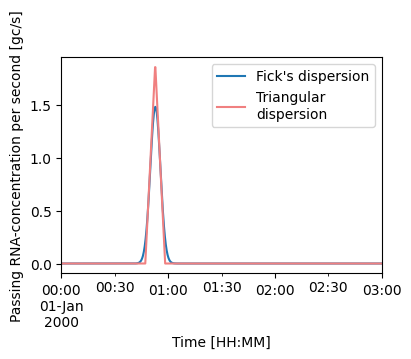

In [76]:
plt.style.use("default")
fig, ax = plt.subplots(figsize=[4,3], constrained_layout=True)
#fig.suptitle("Comparison of Fick's dispersion\n with the simplified triangular model")

tm = int(round(packets.loc[pmaxid,"tm"] % 8640, 0))
age = float(packets.loc[pmaxid,"dt"]) * 10

#timeseries[pmaxid].plot(ax=ax)
ax.set(xlabel="Time [HH:MM]", ylabel="Passing RNA-concentration per second [gc/s]")
indexer = concentrations.loc[concentrations != 0].index

locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.DateFormatter('%H:%M')#locator
ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_major_formatter(formatter)

def time_formatter(t, pos):
    return pd.to_datetime(t).strftime("%H:%M")

ax.xaxis.set_major_formatter(time_formatter)

# assign date locator / formatter to the x-axis to get proper labels
#ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))

#ax.set(xlim=[mdates.date2num(pd.to_datetime("2000-01-01 00:00:00")),
#             mdates.date2num(pd.to_datetime("2000-01-01 03:00:00"))])

disp_fick(tm, age).plot(ax=ax)
#concentrations.plot(ax=ax)
disp_simp(tm, age).plot(color="lightcoral", ax=ax)

#ax.set(xlim=[indexer[0], indexer[-1]])
ax.set(xlim=[pd.to_datetime("2000-01-01 00:00:00").to_pydatetime(), pd.to_datetime("2000-01-01 03:00:00").to_pydatetime()])

plt.legend(["Fick's dispersion","Triangular\ndispersion"])

#plt.savefig(r"C:\Users\albert\Nextcloud\Documents\Doktorat\swmmPulse\paper\grafics\disp_comp.svg")
#plt.savefig(r"C:\Users\albert\Nextcloud\Documents\Doktorat\swmmPulse\paper\grafics\disp_comp.png", dpi=700)

In [18]:
print(f"load ficks: {concentrations.sum() * 10 * flow_velocity}")
print(f"load simpl: {timeseries[pmaxid].sum().values[0] * 10 * flow_velocity}")
print(f"load simpl soll: {disp_simp(tm, age).sum() * 10 * flow_velocity}\n")
print(f"repr. load: {disp_simp(tm, age).sum()/concentrations.sum():.1%}")

load ficks: 820.1381546612563
load simpl: 820.9860697995632
load simpl soll: 820.9860697995632

repr. load: 100.1%


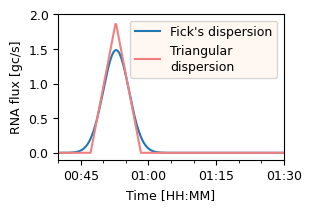

In [138]:
plt.style.use("default")
plt.rcParams.update({'font.size': 9})

fig, ax = plt.subplots(figsize=[3,2], constrained_layout=True, facecolor="white")

# assign date locator / formatter to the x-axis to get proper labels
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.DateFormatter('%H:%M')#locator
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(n=3))
ax.set(xlim=[mdates.date2num(pd.to_datetime("2000-01-01 00:40:00")),
                 mdates.date2num(pd.to_datetime("2000-01-01 01:30:00"))],
       ylim=[-0.1,2.0])
ax.set(xlabel="Time [HH:MM]", ylabel="RNA flux [gc/s]")

s_fick = disp_fick(tm, age)
s_simp = disp_simp(tm, age)
df = pd.concat([s_fick, s_simp], axis=1)
df.to_parquet(r"C:\Users\albert\Documents\SWMMpulse\plots\grfk_dispersions\disp_comp.parquet")
df = df.set_index(mdates.date2num(df.index))

df["fick"].plot(ax=ax)
#concentrations.plot(ax=ax)
df["simp"].plot(color="lightcoral", ax=ax)
#mdates.date2num(pd.to_datetime(sampletime))

ax.legend(["Fick's dispersion","Triangular\ndispersion"], facecolor='seashell')

plt.savefig(r"C:\Users\albert\Documents\SWMMpulse\plots\grfk_dispersions\disp_comp.svg")
plt.savefig(r"C:\Users\albert\Documents\SWMMpulse\plots\grfk_dispersions\disp_comp.png", dpi=700)

In [121]:
s_fick = disp_fick(tm, age)
s_simp = disp_simp(tm, age)
pd.concat([s_fick, s_simp], axis=1)

,fick,simp
2000-01-01 00:00:00,2.421510e-75,0.0
2000-01-01 00:00:10,7.164489e-75,0.0
2000-01-01 00:00:20,2.112495e-74,0.0
2000-01-01 00:00:30,6.207514e-74,0.0
2000-01-01 00:00:40,1.817822e-73,0.0
...,...,...
2000-01-01 23:59:10,0.000000e+00,0.0
2000-01-01 23:59:20,0.000000e+00,0.0
2000-01-01 23:59:30,0.000000e+00,0.0
2000-01-01 23:59:40,0.000000e+00,0.0


In [85]:
df_fick = pd.DataFrame(disp_fick(tm, age))
df_fick["dtindex"] = mdates.date2num(df_fick.index)
df_fick

,0,dtindex
2000-01-01 00:00:00,2.421510e-75,10957.000000
2000-01-01 00:00:10,7.164489e-75,10957.000116
2000-01-01 00:00:20,2.112495e-74,10957.000231
2000-01-01 00:00:30,6.207514e-74,10957.000347
2000-01-01 00:00:40,1.817822e-73,10957.000463
...,...,...
2000-01-01 23:59:10,0.000000e+00,10957.999421
2000-01-01 23:59:20,0.000000e+00,10957.999537
2000-01-01 23:59:30,0.000000e+00,10957.999653
2000-01-01 23:59:40,0.000000e+00,10957.999769


In [90]:
disp_simp(tm, age).index

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 00:00:10',
               '2000-01-01 00:00:20', '2000-01-01 00:00:30',
               '2000-01-01 00:00:40', '2000-01-01 00:00:50',
               '2000-01-01 00:01:00', '2000-01-01 00:01:10',
               '2000-01-01 00:01:20', '2000-01-01 00:01:30',
               ...
               '2000-01-01 23:58:20', '2000-01-01 23:58:30',
               '2000-01-01 23:58:40', '2000-01-01 23:58:50',
               '2000-01-01 23:59:00', '2000-01-01 23:59:10',
               '2000-01-01 23:59:20', '2000-01-01 23:59:30',
               '2000-01-01 23:59:40', '2000-01-01 23:59:50'],
              dtype='datetime64[ns]', length=8640, freq='10S')